In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time
from scipy.stats import rankdata
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal
from scipy.stats import bernoulli

In [2]:
N = 500
M = 5000
a = np.zeros(M)
b = np.zeros(M)
m = np.zeros(M)
n = np.zeros(M)

for i in range(M-10):
    m[i] = np.random.binomial(N, 1/3)
    n[i] = np.random.binomial(N-m[i], 1/2)
    a[i] = np.random.binomial(m[i], 1/2)
    b[i] = np.random.binomial(n[i], 1/2)

for i in range(M-10,M):
    m[i] = np.random.binomial(N, 1/3)
    n[i] = np.random.binomial(N-m[i], 1/2)
    a[i] = np.random.binomial(m[i], 2/3)
    b[i] = np.random.binomial(n[i], 2/3)

stats = np.zeros(M)
order = np.zeros(M)

for i in range(M):
    order[i] = i
    if m[i] == 0:
        f = 0
    else:
        f = (2*a[i]-m[i])**2/m[i]
    if n[i] == 0:
        s = 0
    else:
        s = (2*b[i]-n[i])**2/n[i]
    if m[i] + n[i] == N:
        t = 0
    else:
        t = (2*a[i]+2*b[i]-m[i]-n[i])**2/(N-m[i]-n[i])
    
    stats[i] = f + s + t

x = np.argsort(stats)
#for i in range(10):
#    print(x[M-1-i])

stats = sorted(stats, reverse=True)
#print(sorted_stats)

In [3]:
def HaarMatrix(N):
    A = np.zeros((N,N))
    for j in range(0,N):
        A[0,j] = 1/np.sqrt(N)
    for i in range(1,N):
        for j in range(0,N):
            if N*(i-2**(np.floor(math.log2(i))))/(2**(np.floor(math.log2(i)))) <= j and j < N*(i-2**(np.floor(math.log2(i))) + 1/2)/(2**(np.floor(math.log2(i)))):
                A[i,j] = 2**(np.floor(math.log2(i))/2)/np.sqrt(N)
            elif N*(i-2**(np.floor(math.log2(i))) + 1/2)/(2**(np.floor(math.log2(i)))) <= j and j < N*(i-2**(np.floor(math.log2(i))) + 1)/(2**(np.floor(math.log2(i)))):
                A[i,j] = -2**(np.floor(math.log2(i))/2)/np.sqrt(N)
    return A

In [4]:
def BernoulliMatrix(K,N):
    phi = np.zeros((K,N))
    
    for i in range(K):
        for j in range(N):
            phi[i][j] = bernoulli.rvs(0.5, size=1)

    return (phi - 1/2) / (np.sqrt(K) / 2)

In [5]:
def OMP(A, y, N, K):
    x = np.zeros(N)
    S = np.zeros(N, dtype = np.uint8)
    r = y
    rr = np.dot(r,r)
    
    for i in range(K):
        err = rr - np.dot(A[:,S == 0].T, r) ** 2
        ndx = np.where(S == 0)[0]
        S[ndx[err.argmin()]] = 1
        
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S==1] = np.dot(As.T, np.dot(pinv, y))
        
        r = y - np.dot(A, x)
        rr = np.dot(r,r)
    
    return x

def OMPCL(A, y, N, K):
    x = np.zeros(N)
    S = np.zeros(N, dtype = np.uint8)
    
    for i in range(K):
        for j in range(K):
            S[j] = 1
        
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S==1] = np.dot(As.T, np.dot(pinv, y))
    
    return x

In [6]:
def determineS(n,d,psi,eta):
    xx = np.dot(psi.T, d)
    
    s = 0
    for i in range(n):
        if xx[i] > eta:
            s += 1
    
    if s == 0:
        s = 10
    
    return s

In [7]:
def CompressiveMechanism(g, deltag, K, epsilon, eta, phiphi, psi, AA, ss, kk):
    m = np.size(g)
    n = int(2**(np.ceil(math.log2(m))))
    
    d = np.zeros(n)
    for i in range(m):
        d[i] = g[i]
    
    y = np.dot(phiphi, d)
    pri_y = y + np.random.laplace(loc = 0.0, scale = 2*K*deltag*np.sqrt(kk)/epsilon, size=kk)
    
    pri_x = OMP(AA, pri_y, n, ss)
    
    pri_d = np.dot(psi, pri_x)
    pri_g = np.zeros(m)
    for i in range(m):
        pri_g = pri_d
    
    return pri_g

In [8]:
def CompLaplace(g, deltag, s, K, epsilon, phi, psi, A, k):
    m = np.size(g)
    n = int(2**(np.ceil(math.log2(m))))
    
    t = g[int(s)-1]
    
    x = np.zeros(n)
    for i in range(n):
        if i < m and g[i] >= t:
            x[i] = g[i]
        else:
            x[i] = 0
    
    y = np.dot(A, x)
    
    noise = (2*K/epsilon)*np.sqrt(k)*deltag*((1+(np.sqrt(n)-1)*(np.sqrt(2)+1))/np.sqrt(n))
    pri_y = y + np.random.laplace(loc = 0.0, scale = noise, size = k)
    
    pri_x = OMPCL(A, pri_y, n, s)
    
    pri_g = g + np.random.laplace(loc = 0.0, scale = 2*K*deltag/epsilon, size=m)
    
    for i in range(m):
        if g[i] >= t:
            pri_g[i] = pri_x[i]
    
    return pri_g

In [9]:
def lap_noise_normal(data, K, epsilon):
    pri_data = data + np.random.laplace(loc = 0.0, scale = 2*K*(4*N/(N+2))/epsilon, size=np.size(data))
    
    return pri_data

In [10]:
def random_num(pd):
    dist = np.cumsum(pd).tolist()
    dist[-1] = 1.0
    num = np.random.rand()
    dist.append(num)
    return sorted(dist).index(num)

def exp_mec(stats, s, m, K, epsilon):
    h = np.zeros(m)
    for i in range(m):
        h[i] = stats[i]
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * h[i] / (2*K*s))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
            
        x = random_num(p)
        h[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

In [11]:
def accuracy(g, deltag, K, epsilon,eta, s, m, phi, phiphi, psi, A, AA, ss, k, kk):
    correct = np.zeros(4)
    for j in range(3):
        pri_comp_data = CompressiveMechanism(g, deltag, K, epsilon,eta, phiphi, psi, AA, ss, kk)
        pri_comp_rank = rankdata(-pri_comp_data)
        #print(pri_comp_rank[0:20])
        #print(g[0:20])
        
        pri_complap_data = CompLaplace(g, deltag, s, K, epsilon, phi, psi, A, k)
        pri_complap_rank = rankdata(-pri_complap_data)
        #print(pri_complap_rank[0:20])
        #print(g[0:20])
        
        pri_lap_data = lap_noise_normal(g, K, epsilon)
        pri_lap_rank = rankdata(-pri_lap_data)
        #print(pri_lap_rank[0:20])
        #print(g[0:20])
        
        pri_exp_rank = exp_mec(g, deltag, m, K, epsilon)
        #print(pri_exp_rank[0:20])
        #print(g[0:20])
        
        for i in range(K):
            if pri_comp_rank[i] <= K:
                correct[0] += 1
            if pri_complap_rank[i] <= K:
                correct[1] += 1
            if pri_lap_rank[i] <= K:
                correct[2] += 1
            if pri_exp_rank[i] < K:
                correct[3] += 1
    
    acc = correct/(K*3)
    return acc

[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.33333333 0.         0.        ]
 [0.         0.         0.66666667 0.        ]
 [0.         0.         1.         1.        ]
 [0.         0.33333333 1.         1.        ]]
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.33333333 0.66666667 0.66666667]
 [0.         0.         1.         1.        ]
 [0.         0.         1.         1.        ]]
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.33333333 0.         0.        ]
 [0.         0.33333333 1.         0.66666667]
 [0.         0.33333333 1.         1.        ]
 [0.         0.33333333 1.         1.        ]]
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.      

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.33333333 0.66666667]
 [0.         0.         1.         1.        ]
 [0.         0.         1.         0.66666667]]


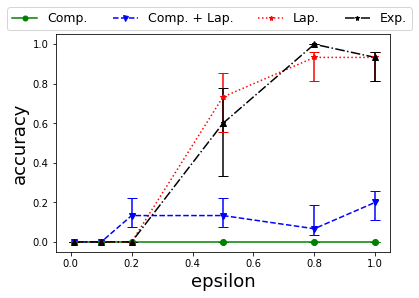

In [12]:
eta = 10
s = 10

n = int(2**(np.ceil(math.log2(M))))
k = int(np.floor(s*math.log(n/s)))

d = np.zeros(n)
for i in range(M):
    d[i] = stats[i]
    
psi = HaarMatrix(n)
ss = determineS(n,d,psi,eta)
kk = int(np.floor(ss*math.log(n/ss)))
    
phiphi = BernoulliMatrix(kk,n)
AA = np.dot(phiphi, psi)

phi = BernoulliMatrix(k,n)
A = np.dot(phi, psi)

K = 1

acc = np.zeros((6,4))
max_acc = np.zeros((6,4))
min_acc = np.ones((6,4))
sum_acc = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        acc[i] = accuracy(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if acc[i][0] > max_acc[i][0]:
            max_acc[i][0] = acc[i][0]
        if acc[i][0] < min_acc[i][0]:
            min_acc[i][0] = acc[i][0]
        if acc[i][1] > max_acc[i][1]:
            max_acc[i][1] = acc[i][1]
        if acc[i][1] < min_acc[i][1]:
            min_acc[i][1] = acc[i][1]
        if acc[i][2] > max_acc[i][2]:
            max_acc[i][2] = acc[i][2]
        if acc[i][2] < min_acc[i][2]:
            min_acc[i][2] = acc[i][2]
        if acc[i][3] > max_acc[i][3]:
            max_acc[i][3] = acc[i][3]
        if acc[i][3] < min_acc[i][3]:
            min_acc[i][3] = acc[i][3]
        sum_acc[i][0] += acc[i][0]
        sum_acc[i][1] += acc[i][1]
        sum_acc[i][2] += acc[i][2]
        sum_acc[i][3] += acc[i][3]
    print(acc)

acc = sum_acc / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = acc[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - acc[:,0]
y_err[0,:,1] = acc[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - acc[:,1]
y_err[0,:,2] = acc[:,2] - min_acc[:,2]
y_err[1,:,2] = max_acc[:,2] - acc[:,2]
y_err[0,:,3] = acc[:,3] - min_acc[:,3]
y_err[1,:,3] = max_acc[:,3] - acc[:,3]
y_err /= np.sqrt(5)

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, acc[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, acc[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, acc[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, acc[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, acc[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, acc[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, acc[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, acc[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.46, 1.02), loc='lower center', borderaxespad=0, ncol=4, fontsize=12.5)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("accuracy_large_K=1.png")
fig.savefig("fig/accuracy_large_K=1.eps")

[[0.         0.22222222 0.         0.        ]
 [0.         0.11111111 0.         0.        ]
 [0.         0.33333333 0.         0.11111111]
 [0.         0.33333333 0.11111111 0.        ]
 [0.         0.22222222 0.22222222 0.11111111]
 [0.         0.33333333 0.55555556 0.44444444]]
[[0.         0.22222222 0.         0.        ]
 [0.         0.22222222 0.         0.11111111]
 [0.         0.33333333 0.         0.        ]
 [0.         0.33333333 0.         0.        ]
 [0.         0.55555556 0.11111111 0.        ]
 [0.         0.55555556 0.66666667 0.22222222]]
[[0.         0.44444444 0.         0.        ]
 [0.         0.33333333 0.         0.        ]
 [0.         0.22222222 0.         0.        ]
 [0.         0.22222222 0.         0.        ]
 [0.         0.33333333 0.         0.33333333]
 [0.         0.22222222 0.33333333 0.44444444]]
[[0.         0.22222222 0.         0.        ]
 [0.         0.22222222 0.         0.        ]
 [0.         0.55555556 0.         0.        ]
 [0.      

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.         0.44444444 0.         0.        ]
 [0.         0.22222222 0.         0.        ]
 [0.         0.44444444 0.         0.        ]
 [0.         0.33333333 0.         0.        ]
 [0.         0.11111111 0.11111111 0.22222222]
 [0.         0.33333333 0.11111111 0.44444444]]


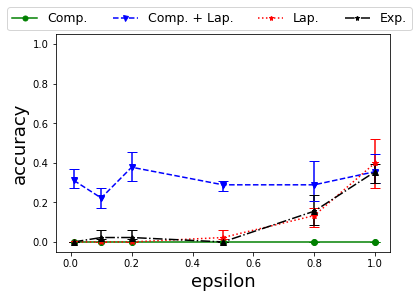

In [13]:
eta = 10
s = 10

K = 3

acc = np.zeros((6,4))
max_acc = np.zeros((6,4))
min_acc = np.ones((6,4))
sum_acc = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        acc[i] = accuracy(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if acc[i][0] > max_acc[i][0]:
            max_acc[i][0] = acc[i][0]
        if acc[i][0] < min_acc[i][0]:
            min_acc[i][0] = acc[i][0]
        if acc[i][1] > max_acc[i][1]:
            max_acc[i][1] = acc[i][1]
        if acc[i][1] < min_acc[i][1]:
            min_acc[i][1] = acc[i][1]
        if acc[i][2] > max_acc[i][2]:
            max_acc[i][2] = acc[i][2]
        if acc[i][2] < min_acc[i][2]:
            min_acc[i][2] = acc[i][2]
        if acc[i][3] > max_acc[i][3]:
            max_acc[i][3] = acc[i][3]
        if acc[i][3] < min_acc[i][3]:
            min_acc[i][3] = acc[i][3]
        sum_acc[i][0] += acc[i][0]
        sum_acc[i][1] += acc[i][1]
        sum_acc[i][2] += acc[i][2]
        sum_acc[i][3] += acc[i][3]
    print(acc)

acc = sum_acc / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = acc[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - acc[:,0]
y_err[0,:,1] = acc[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - acc[:,1]
y_err[0,:,2] = acc[:,2] - min_acc[:,2]
y_err[1,:,2] = max_acc[:,2] - acc[:,2]
y_err[0,:,3] = acc[:,3] - min_acc[:,3]
y_err[1,:,3] = max_acc[:,3] - acc[:,3]
y_err /= np.sqrt(5)

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, acc[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, acc[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, acc[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, acc[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, acc[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, acc[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, acc[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, acc[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.46, 1.02), loc='lower center', borderaxespad=0, ncol=4, fontsize=12.5)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("accuracy_large_K=3.png")
fig.savefig("fig/accuracy_large_K=3.eps")

[[0.         0.33333333 0.         0.        ]
 [0.         0.4        0.         0.06666667]
 [0.         0.53333333 0.         0.        ]
 [0.         0.53333333 0.         0.        ]
 [0.         0.4        0.         0.06666667]
 [0.         0.6        0.06666667 0.13333333]]
[[0.         0.4        0.         0.        ]
 [0.         0.33333333 0.         0.        ]
 [0.         0.4        0.06666667 0.        ]
 [0.         0.53333333 0.06666667 0.        ]
 [0.         0.4        0.         0.        ]
 [0.         0.33333333 0.06666667 0.        ]]
[[0.         0.26666667 0.         0.        ]
 [0.         0.4        0.         0.        ]
 [0.         0.33333333 0.         0.        ]
 [0.         0.33333333 0.         0.        ]
 [0.         0.4        0.13333333 0.        ]
 [0.         0.4        0.13333333 0.13333333]]
[[0.         0.4        0.         0.        ]
 [0.         0.53333333 0.         0.        ]
 [0.         0.33333333 0.         0.        ]
 [0.      

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.         0.4        0.         0.        ]
 [0.         0.26666667 0.         0.        ]
 [0.         0.6        0.         0.        ]
 [0.         0.66666667 0.         0.        ]
 [0.         0.46666667 0.         0.        ]
 [0.         0.4        0.06666667 0.        ]]


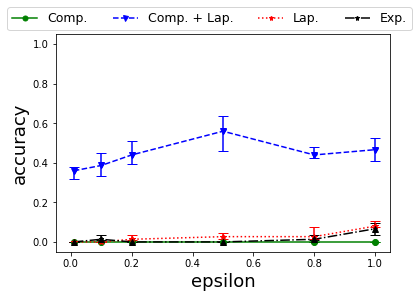

In [14]:
eta = 10
s = 10

K = 5

acc = np.zeros((6,4))
max_acc = np.zeros((6,4))
min_acc = np.ones((6,4))
sum_acc = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        acc[i] = accuracy(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if acc[i][0] > max_acc[i][0]:
            max_acc[i][0] = acc[i][0]
        if acc[i][0] < min_acc[i][0]:
            min_acc[i][0] = acc[i][0]
        if acc[i][1] > max_acc[i][1]:
            max_acc[i][1] = acc[i][1]
        if acc[i][1] < min_acc[i][1]:
            min_acc[i][1] = acc[i][1]
        if acc[i][2] > max_acc[i][2]:
            max_acc[i][2] = acc[i][2]
        if acc[i][2] < min_acc[i][2]:
            min_acc[i][2] = acc[i][2]
        if acc[i][3] > max_acc[i][3]:
            max_acc[i][3] = acc[i][3]
        if acc[i][3] < min_acc[i][3]:
            min_acc[i][3] = acc[i][3]
        sum_acc[i][0] += acc[i][0]
        sum_acc[i][1] += acc[i][1]
        sum_acc[i][2] += acc[i][2]
        sum_acc[i][3] += acc[i][3]
    print(acc)

acc = sum_acc / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = acc[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - acc[:,0]
y_err[0,:,1] = acc[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - acc[:,1]
y_err[0,:,2] = acc[:,2] - min_acc[:,2]
y_err[1,:,2] = max_acc[:,2] - acc[:,2]
y_err[0,:,3] = acc[:,3] - min_acc[:,3]
y_err[1,:,3] = max_acc[:,3] - acc[:,3]
y_err /= np.sqrt(5)

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, acc[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, acc[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, acc[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, acc[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, acc[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, acc[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, acc[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, acc[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.46, 1.02), loc='lower center', borderaxespad=0, ncol=4, fontsize=12.5)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("accuracy_large_K=5.png")
fig.savefig("fig/accuracy_large_K=5.eps")

[[0.         0.26666667 0.         0.        ]
 [0.         0.53333333 0.         0.        ]
 [0.         0.43333333 0.         0.        ]
 [0.         0.43333333 0.         0.        ]
 [0.         0.5        0.         0.        ]
 [0.         0.43333333 0.         0.06666667]]
[[0.         0.43333333 0.         0.        ]
 [0.         0.5        0.         0.        ]
 [0.         0.6        0.         0.        ]
 [0.         0.36666667 0.         0.        ]
 [0.         0.43333333 0.         0.        ]
 [0.         0.33333333 0.03333333 0.03333333]]
[[0.         0.4        0.         0.06666667]
 [0.         0.5        0.03333333 0.        ]
 [0.         0.5        0.         0.        ]
 [0.         0.36666667 0.         0.        ]
 [0.         0.43333333 0.         0.        ]
 [0.         0.43333333 0.03333333 0.06666667]]
[[0.         0.43333333 0.         0.        ]
 [0.         0.4        0.         0.        ]
 [0.         0.5        0.         0.        ]
 [0.      

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[[0.         0.46666667 0.         0.        ]
 [0.         0.3        0.         0.        ]
 [0.         0.26666667 0.         0.        ]
 [0.         0.56666667 0.         0.        ]
 [0.         0.4        0.         0.        ]
 [0.         0.4        0.         0.03333333]]


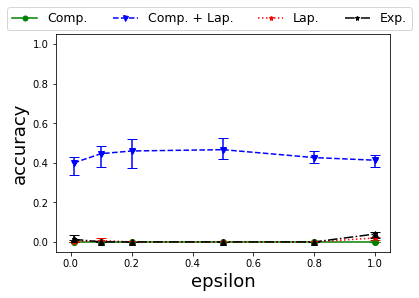

In [15]:
eta = 10
s = 10

K = 10

acc = np.zeros((6,4))
max_acc = np.zeros((6,4))
min_acc = np.ones((6,4))
sum_acc = np.zeros((6,4))

epsilon = [0.01, 0.1, 0.2, 0.5, 0.8, 1.0]

for j in range(5):
    for i in range(6):
        acc[i] = accuracy(stats, 4*N/(N+2), K, epsilon[i], eta, s, M, phi, phiphi, psi, A, AA, ss, k, kk)
        
        if acc[i][0] > max_acc[i][0]:
            max_acc[i][0] = acc[i][0]
        if acc[i][0] < min_acc[i][0]:
            min_acc[i][0] = acc[i][0]
        if acc[i][1] > max_acc[i][1]:
            max_acc[i][1] = acc[i][1]
        if acc[i][1] < min_acc[i][1]:
            min_acc[i][1] = acc[i][1]
        if acc[i][2] > max_acc[i][2]:
            max_acc[i][2] = acc[i][2]
        if acc[i][2] < min_acc[i][2]:
            min_acc[i][2] = acc[i][2]
        if acc[i][3] > max_acc[i][3]:
            max_acc[i][3] = acc[i][3]
        if acc[i][3] < min_acc[i][3]:
            min_acc[i][3] = acc[i][3]
        sum_acc[i][0] += acc[i][0]
        sum_acc[i][1] += acc[i][1]
        sum_acc[i][2] += acc[i][2]
        sum_acc[i][3] += acc[i][3]
    print(acc)

acc = sum_acc / 5

y_err = np.zeros((2,6,4))

y_err[0,:,0] = acc[:,0] - min_acc[:,0]
y_err[1,:,0] = max_acc[:,0] - acc[:,0]
y_err[0,:,1] = acc[:,1] - min_acc[:,1]
y_err[1,:,1] = max_acc[:,1] - acc[:,1]
y_err[0,:,2] = acc[:,2] - min_acc[:,2]
y_err[1,:,2] = max_acc[:,2] - acc[:,2]
y_err[0,:,3] = acc[:,3] - min_acc[:,3]
y_err[1,:,3] = max_acc[:,3] - acc[:,3]
y_err /= np.sqrt(5)

fig = plt.figure()
plt.ylim(-0.05, 1.05)
plt.xlim(-0.05, 1.05)
plt.errorbar(epsilon, acc[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(epsilon, acc[:,0], marker="o", markersize=5, color = "green", linestyle = "-", label = "Comp.")
plt.errorbar(epsilon, acc[:,1], yerr = y_err[:,:,1], capsize=5, fmt='v', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(epsilon, acc[:,1], marker="v", markersize=5, color = "blue", linestyle = "--", label = "Comp. + Lap.")
plt.errorbar(epsilon, acc[:,2], yerr = y_err[:,:,2], capsize=5, fmt='*', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(epsilon, acc[:,2], marker="*", markersize=5, color = "red", linestyle = "dotted", label = "Lap.")
plt.errorbar(epsilon, acc[:,3], yerr = y_err[:,:,3], capsize=5, fmt='^', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(epsilon, acc[:,3], marker="*", markersize=5, color = "black", linestyle = "dashdot", label = "Exp.")
plt.legend(bbox_to_anchor=(0.46, 1.02), loc='lower center', borderaxespad=0, ncol=4, fontsize=12.5)
plt.xlabel("epsilon", fontsize = 18)
plt.ylabel("accuracy", fontsize = 18)
fig.savefig("accuracy_large_K=10.png")
fig.savefig("fig/accuracy_large_K=10.eps")